# FKM Nonlinear example
The algorithm follows the document "RICHTLINIE NICHTLINEAR / Rechnerischer Festigkeitsnachweis unter expliziter Erfassung nichtlinearen Werkstoffverformungsverhaltens / Für Bauteile aus Stahl, Stahlguss und Aluminiumknetlegierungen / 1.Auflage, 2019"

The used values are according to "Akademisches Beispiel", chapter 2.7.1.

*Note that this notebook is for demonstration of the algorithm, for actual assessment use other notebooks, e.g., [fkm_nonlinear](fkm_nonlinear.ipynb)*

#### Python module imports

In [1]:
# standard modules
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import copy

# pylife
import pylife
import pylife.vmap
import pylife.stress.equistress
import pylife.strength.fkm_load_distribution
import pylife.strength.fkm_nonlinear
import pylife.strength.fkm_nonlinear.damage_calculator
import pylife.strength.damage_parameter
import pylife.strength.woehler_fkm_nonlinear
import pylife.materiallaws
import pylife.stress.rainflow
import pylife.stress.rainflow.recorders
import pylife.stress.rainflow.fkm_nonlinear
import pylife.materiallaws.notch_approximation_law
import pylife.materiallaws.notch_approximation_law_seegerbeste

import pylife.strength.fkm_nonlinear.parameter_calculations as parameter_calculations

## 2.6.1 Collect all input data

#### Material parameters

In [2]:
assessment_parameters = pd.Series({
        'MatGroupFKM': 'Steel',  # [Steel, SteelCast, Al_wrought] material group
        'FinishingFKM': 'none',  # type of surface finisihing
        'R_m': 600,              # [MPa] ultimate tensile strength (de: Zugfestigkeit)
        #'K_RP': 1,               # [-] surface roughness factor, set to 1 for polished surfaces or determine from the diagrams below
        'R_z': 250,              # [um] average roughness (de: mittlere Rauheit), only required if K_RP is not specified directly
    
        'P_A': 7.2e-5,           # [-] failure probability, set to 0.5 to not consider additional safety (de: auszulegende Ausfallwahrscheinlichkeit)
        # beta: 0.5,             # damage index, specify this as an alternative to P_A
    
        'P_L': 2.5,              # [%] (one of 2.5%, 50%) (de: Auftretenswahrscheinlilchkeit der Lastfolge)
        'c':   3,              # [MPa/N] (de: Übertragungsfaktor Vergleichsspannung zu Referenzlast im Nachweispunkt, c = sigma_I / L_REF)
        'A_sigma': 339.4,        # [mm^2] (de: Hochbeanspruchte Oberfläche des Bauteils)
        'A_ref': 500,            # [mm^2] (de: Hochbeanspruchte Oberfläche eines Referenzvolumens), usually set to 500
        'G': 2/15,               # [mm^-1] (de: bezogener Spannungsgradient)
        's_L': 10,               # [MPa] standard deviation of Gaussian distribution
        'K_p': 3.5,              # [-] (de: Traglastformzahl) K_p = F_plastic / F_yield (3.1.1)
        'r': 15,                 # [mm] radius (?)
})

## Notes on the parameters
### The highly loaded surface $A_\sigma$
The highly loaded surface parameter $A_\sigma$ is needed when the expected fracture starts at the component's surface. It can be computed using the algorithm "SPIEL" as described in the FKM guideline nonlinear. (cf. chapter 3.1.2). For simple common geometries like notched plates and shafts, table 2.6 of the FKM guideline nonlinear presents formulas for $A_\sigma$.

### The relative stress gradient $G$
The relative stress gradient $G$ is usually determined from finite element calculations, but can also be estimated by heuristic, cf. eq. (2.5-34) in the FKM guideline nonlinear.

### The surface roughness factor $K_{R,P}$
The factor of surface roughness can either be manually specified in the ``assessment_parameters`` variable. If it is omitted, the FKM formula is used to estimate it from ultimate tensile strength, $R_m$, and surface roughness, $R_z$.
For polished components, the factor should be set to $K_{R,P}=1$. For other materials, it can be retrieved from the  diagrams in Fig. 2.8 in the FKM guideline nonlinear.

### The safety factor of the component and the failure probability $P_A$
For calculations that should be compared with cyclic experiments, set the failure probability to $P_A=50\%$.
For added safety in assessment concepts, the FKM guideline nonlinear suggests the following failure probabilities ``P_A``:
* Redundant components: $P_A=2.3\cdot 10^{-1}$, $P_A=10^{-3}$, and $P_A=7.2\cdot 10^{-5}$ for moderate, severe, and very severe failure consequences, respectively.
* Non-redundant components: $P_A=10^{-3}$, $P_A=7.2\cdot 10^{-5}$, and $P_A=10^{-5}$ for moderate, severe, and very severe failure consequences, respectively.

You can additionally specify the parameter ``beta`` (de: Zuverlässigkeitsindex) for the material, which then will be used to compute the material safety factor $\gamma_M$. For $P_A=50\%$ set ``gamma_M=1``.

#### Load sequence

Text(0, 0.5, 'F')

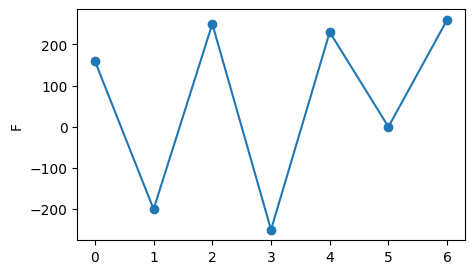

In [3]:
load_sequence = pd.Series([160, -200, 250, -250, 230, 0, 260])  # [N]

fig = plt.figure(figsize=(5,3))
plt.plot(load_sequence, "o-")
plt.ylabel("F")

### Estimate tensile strength $R_m$ from nominal value $R_{m,N}$

There are three possible methods to consider the statistical distribution of the load:
* A normal distribution with given standard deviation, $s_L$
* A logarithmic-normal distribution with given standard deviation $LSD_s$
* An unknown distribution, instead use a constant factor $P_L = 2.5\%$

In [5]:
# Choose one of the following three lines:

# FKMLoadDistributionNormal, uses assessment_parameters.s_L, assessment_parameters.P_L, assessment_parameters.P_A
scaled_load_sequence = load_sequence.fkm_safety_normal_from_stddev.scaled_load_sequence(assessment_parameters)
gamma_L = load_sequence.fkm_safety_normal_from_stddev.gamma_L(assessment_parameters)
print(f"scaling factor gamma_L: {gamma_L:.5f}")

# FKMLoadDistributionLognormal, uses assessment_parameters.LSD_s, assessment_parameters.P_L, assessment_parameters.P_A
assessment_parameters["LSD_s"] = 1
#scaled_load_sequence = load_sequence.fkm_safety_lognormal_from_stddev.scaled_load_sequence(assessment_parameters)

# FKMLoadDistributionBlanket, uses input_parameters.P_L
#scaled_load_sequence = load_sequence.fkm_safety_blanket.scaled_load_sequence(assessment_parameters)

# 79

scaling factor gamma_L: 1.02538


Compute load sequence for lifetime assessment, $L = c \cdot \gamma_L \cdot \mathcal{L}$ with $c = \dfrac{\sigma_V}{L_{REF}}$.  
See 2.3.3, 2.3.4

0    492.184615
1   -615.230769
2    769.038462
3   -769.038462
4    707.515385
5      0.000000
6    799.800000
dtype: float64

Text(0, 0.5, '$\\sigma_V$ [MPa]')

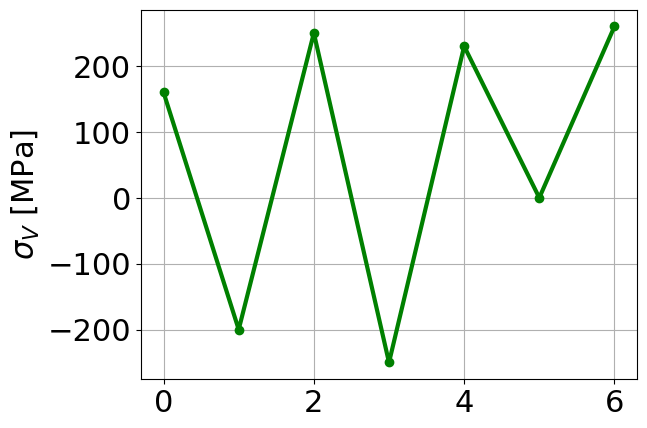

In [6]:
# scale load sequence by reference load
#c = 1/L_REF
c = assessment_parameters.c
scaled_load_sequence = c * gamma_L * load_sequence
display(scaled_load_sequence)

# plot load sequence
plt.rcParams.update({'font.size': 22})
plt.plot(range(len(scaled_load_sequence)), load_sequence, "o-", c="g", lw=3)
plt.grid()
plt.ylabel("$\sigma_V$ [MPa]")

## 2.6.3  Determine cyclic material parameters according to Ramberg-Osgood
This can be done by experiments or by the formulas given in the guideline. This Jupyter notebook uses the implemented formulas. So far, we have specified the following quantities.

In [7]:
assessment_parameters

MatGroupFKM                            Steel
FinishingFKM                            none
R_m                                      600
R_z                                      250
P_A                                 0.000072
P_L                                      2.5
c                                          3
A_sigma                                339.4
A_ref                                    500
G                                   0.133333
s_L                                       10
K_p                                      3.5
r                                         15
max_load_independently_for_nodes       False
LSD_s                                      1
dtype: object

In [8]:
assessment_parameters = pylife.strength.fkm_nonlinear.parameter_calculations.calculate_cyclic_assessment_parameters(assessment_parameters)

## 2.6.4 Estimate material SN-curve (Werkstoff-Wöhlerlinie)

#### 2.5.5.1 Determine from experiments
* Conduct strain-driven experiments with $R_\varepsilon = -1$. Record values for $\sigma_a, \varepsilon_{a,\text{ges}}$ and $N_\text{Werkstoff}$.
* Compute $P_{RAM}=\sqrt{\sigma_a\cdot \varepsilon_{a,\text{ges}} \cdot E}$ for every single experiment.
* Use the maximum-likelihood method to infer the parameters $d_1, d_2, P_{RAM,Z,WS}$. For details, refer to the FKM nonlinear document, Sec. 2.5.5.1, p. 40.

#### 2.5.5.2 Estimate from formulas
Alternatively, estimate the material SN-curve from the ultimate tensile strength $R_m$.

In [9]:
# calculate the parameters for the material woehler curve 
# (for both P_RAM and P_RAJ, the variable names do not interfere)
assessment_parameters = parameter_calculations.calculate_material_woehler_parameters_P_RAM(assessment_parameters)
assessment_parameters = parameter_calculations.calculate_material_woehler_parameters_P_RAJ(assessment_parameters)

## 2.6.5 Estimate component SN-curve (Bauteil-Wöhlerlinie)
Consideration of non-local effects on the lifetime of the component.

### 2.6.5.1, 2.5.6.1 Size and geometry factor $n_P$, Spannungsgradient $G$, $A_\sigma$
Compute the factor for non-local influences, $n_P = n_{bm}(R_m, G) \cdot n_{st}(A_\sigma)$, where $n_{bm}$ is the fracture mechanics factor (de: bruchmechanische Stützzahl) and $n_{st}$ is the statistic factor (de: statistische Stützzahl). The factors depend on the stress gradient, $G$, and the highly loaded surface, $A_\sigma$, respectively.

In [10]:
assessment_parameters = parameter_calculations.calculate_nonlocal_parameters(assessment_parameters)

### 2.6.5.2, 2.5.6.2 Roughness factor $K_{R,P}$
Compute the influence factor of the roughness, $K_{R,P}$, which is estimated based on the ultimate tensile strength, $R_m$, and the surface roughness, $R_z$. See also the diagrams "Abbildung 2.21" show above.

In [11]:
assessment_parameters = parameter_calculations.calculate_roughness_parameter(assessment_parameters)

In [12]:
assessment_parameters = parameter_calculations.calculate_failure_probability_factor_P_RAM(assessment_parameters)
assessment_parameters = parameter_calculations.calculate_failure_probability_factor_P_RAJ(assessment_parameters)

### 2.6.5.3, 2.5.6.3 safety factor $\gamma_M$
Compute the factors to derive the component Wöhler curve from the material Wöhler curve. The factors for both P_RAM and P_RAJ are computed.

In [13]:
assessment_parameters = parameter_calculations.calculate_component_woehler_parameters_P_RAM(assessment_parameters)
assessment_parameters = parameter_calculations.calculate_component_woehler_parameters_P_RAJ(assessment_parameters)

### 2.6.5.4, 2.5.6   formula for component SN-curve

Woehler curve for P_RAM

In [14]:
component_woehler_curve_parameters = assessment_parameters[["P_RAM_Z", "P_RAM_D", "d_1", "d_2"]]
component_woehler_curve_P_RAM = component_woehler_curve_parameters.woehler_P_RAM

Wöhler curve for P_RAJ

In [15]:
component_woehler_curve_parameters = assessment_parameters[["P_RAJ_Z", "P_RAJ_D_0", "d_RAJ"]]
component_woehler_curve_P_RAJ = component_woehler_curve_parameters.woehler_P_RAJ

In [16]:
assessment_parameters

MatGroupFKM                                                                     Steel
FinishingFKM                                                                     none
R_m                                                                               600
R_z                                                                               250
P_A                                                                          0.000072
P_L                                                                               2.5
c                                                                                   3
A_sigma                                                                         339.4
A_ref                                                                             500
G                                                                            0.133333
s_L                                                                                10
K_p                                                   

In [17]:
1/assessment_parameters.d_1, 1/assessment_parameters.d_2, 1/assessment_parameters.d_RAJ

(-3.3112582781456954, -5.0761421319796955, -1.5873015873015872)

In [18]:
assessment_parameters[["P_RAM_Z_WS", "P_RAM_D_WS", "d_1", "d_2"]]

P_RAM_Z_WS     606.82453
P_RAM_D_WS    209.397432
d_1               -0.302
d_2               -0.197
dtype: object

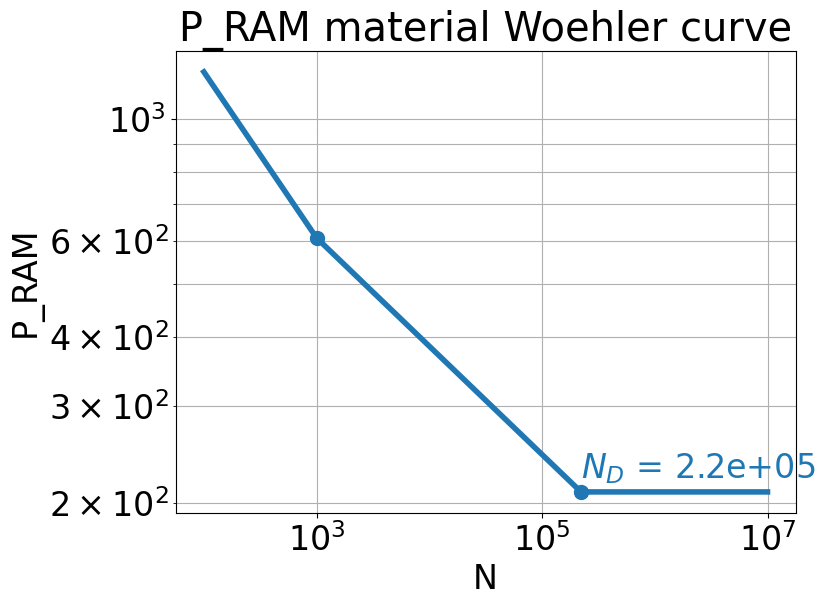

In [19]:
# plot P_RAM material Woehler curve
n_list = np.logspace(2, 7, num=101, endpoint=True, base=10.0)
plt.rcParams.update({'font.size': 24})
fig,ax = plt.subplots(figsize=(8,6))

# for core
material_woehler_curve_parameters = assessment_parameters[["P_RAM_Z_WS", "P_RAM_D_WS", "d_1", "d_2"]]
material_woehler_curve_parameters["P_RAM_Z"] = assessment_parameters["P_RAM_Z_WS"]
material_woehler_curve_parameters["P_RAM_D"] = assessment_parameters["P_RAM_D_WS"]

material_woehler_curve_P_RAM = pylife.strength.woehler_fkm_nonlinear\
    .WoehlerCurvePRAM(material_woehler_curve_parameters)

line = plt.plot(n_list, material_woehler_curve_P_RAM.calc_P_RAM(n_list), "-", lw=4)
plt.plot(1e3, material_woehler_curve_P_RAM.P_RAM_Z, 
         "o", color=line[0].get_color(), markersize=10)
N_D = material_woehler_curve_P_RAM.fatigue_life_limit
plt.plot(N_D, material_woehler_curve_P_RAM.fatigue_strength_limit, 
         "o", color=line[0].get_color(), markersize=10)
plt.annotate(f"$N_D$ = {N_D:.1e}", (N_D, material_woehler_curve_P_RAM.fatigue_strength_limit), 
             textcoords="offset points", xytext=(0,10), color=line[0].get_color())

plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('P_RAM')
plt.title("P_RAM material Woehler curve")
plt.grid(which='both')

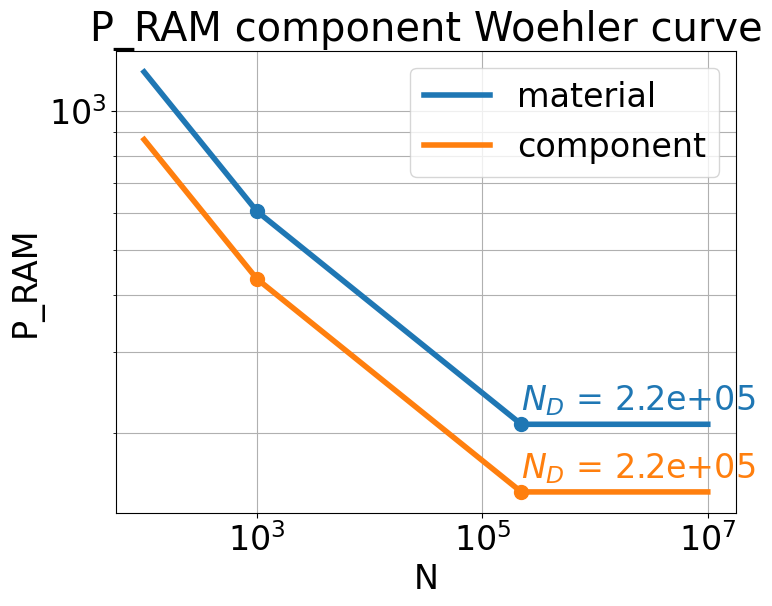

In [20]:
# plot P_RAM component Woehler curve
n_list = np.logspace(2, 7, num=101, endpoint=True, base=10.0)
plt.rcParams.update({'font.size': 24})
fig,ax = plt.subplots(figsize=(8,6))

# for core
component_woehler_curve_parameters = assessment_parameters[["P_RAM_Z", "P_RAM_D", "d_1", "d_2"]]

component_woehler_curve_P_RAM = pylife.strength.woehler_fkm_nonlinear\
    .WoehlerCurvePRAM(component_woehler_curve_parameters)

# material
line = plt.plot(n_list, material_woehler_curve_P_RAM.calc_P_RAM(n_list), "-", lw=4, label="material")
plt.plot(1e3, material_woehler_curve_P_RAM.P_RAM_Z, 
         "o", color=line[0].get_color(), markersize=10)
N_D = material_woehler_curve_P_RAM.fatigue_life_limit
plt.plot(N_D, material_woehler_curve_P_RAM.fatigue_strength_limit, 
         "o", color=line[0].get_color(), markersize=10)
plt.annotate(f"$N_D$ = {N_D:.1e}", (N_D, material_woehler_curve_P_RAM.fatigue_strength_limit), 
             textcoords="offset points", xytext=(0,10), color=line[0].get_color())


# component
line = plt.plot(n_list, component_woehler_curve_P_RAM.calc_P_RAM(n_list), "-", lw=4, label="component")
plt.plot(1e3, component_woehler_curve_P_RAM.P_RAM_Z, 
         "o", color=line[0].get_color(), markersize=10)
N_D = component_woehler_curve_P_RAM.fatigue_life_limit
plt.plot(N_D, component_woehler_curve_P_RAM.fatigue_strength_limit, 
         "o", color=line[0].get_color(), markersize=10)
plt.annotate(f"$N_D$ = {N_D:.1e}", (N_D, component_woehler_curve_P_RAM.fatigue_strength_limit), 
             textcoords="offset points", xytext=(0,10), color=line[0].get_color())

plt.legend(loc="best")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('P_RAM')
plt.title("P_RAM component Woehler curve")
plt.grid(which='both')

## 2.6.7, 2.5.8 Perform HCM rainflow counting
    

* 2.6.6, 2.5.7 Compute stresses and strains, classification, PFAD and AST matrices   
* 2.6.7, 2.5.8.1 HCM algorithm, output (S_a, S_m and epsilon_a) for every hysteresis

In [21]:
# initialize notch approximation law
E, K_prime, n_prime, K_p = assessment_parameters[["E", "K_prime", "n_prime", "K_p"]]
extended_neuber = pylife.materiallaws.notch_approximation_law.ExtendedNeuber(E, K_prime, n_prime, K_p)

load_sequence_list = scaled_load_sequence
print(load_sequence_list)

# wrap the notch approximation law by a binning class, which precomputes the values
maximum_absolute_load = max(np.abs(load_sequence_list))
print(f"maximum_absolute_load: {maximum_absolute_load}")
extended_neuber_binned = pylife.materiallaws.notch_approximation_law.Binned(
    extended_neuber, maximum_absolute_load, 100)

# create recorder object
recorder = pylife.stress.rainflow.recorders.FKMNonlinearRecorder()

# create detector object
detector = pylife.stress.rainflow.fkm_nonlinear.FKMNonlinearDetector(
    recorder=recorder, notch_approximation_law=extended_neuber_binned)

# perform HCM algorithm, first run
detector.process(load_sequence_list, flush=False)
detector_1st = copy.deepcopy(detector)

# perform HCM algorithm, second run
detector.process(load_sequence_list, flush=True)


0    492.184615
1   -615.230769
2    769.038462
3   -769.038462
4    707.515385
5      0.000000
6    799.800000
dtype: float64
maximum_absolute_load: 799.8000000000002


Text(0, 0.5, '$\\sigma$ [MPa]')

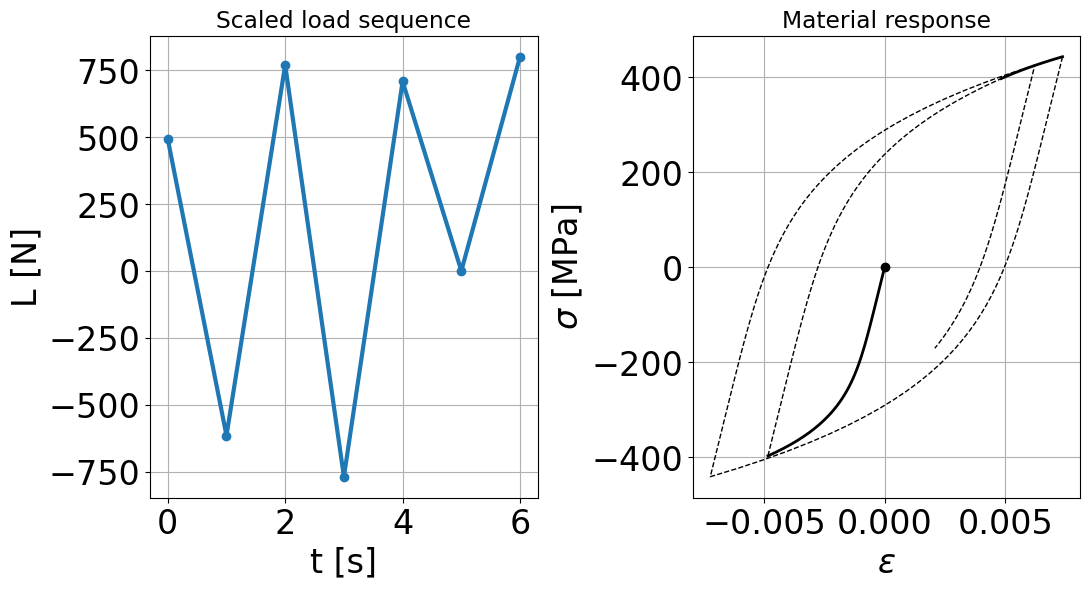

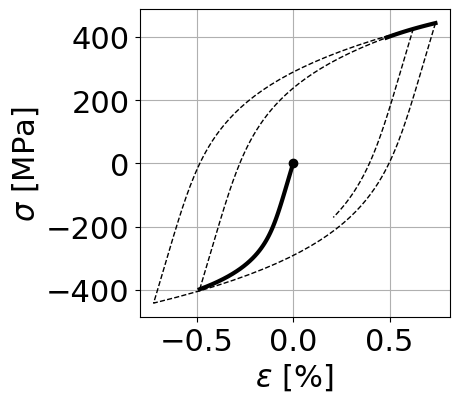

In [22]:
# plot resulting stress-strain curve
sampling_parameter = 50    # choose larger for smoother plot
strain_values_primary, stress_values_primary, hysteresis_index_primary, \
strain_values_secondary, stress_values_secondary, hysteresis_index_secondary \
    = detector_1st.interpolated_stress_strain_data(sampling_parameter)

fig, axes = plt.subplots(1, 2, figsize=(12,6))
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)

# load-time diagram
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
axes[0].plot(load_sequence_list, "o-", lw=3)
axes[0].grid()
axes[0].set_xlabel("t [s]")
axes[0].set_ylabel("L [N]")
axes[0].set_title("Scaled load sequence")

# stress-strain diagram
axes[1].plot(0,0,"ok")
axes[1].plot(strain_values_primary, stress_values_primary, "k-", lw=2)
axes[1].plot(strain_values_secondary, stress_values_secondary, "k--", lw=1)
axes[1].grid()
axes[1].set_xlabel("$\epsilon$")
axes[1].set_ylabel("$\sigma$ [MPa]")
axes[1].set_title("Material response")


# stress-strain diagram
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(0,0,"ok")
ax.plot([e*1e2 for e in strain_values_primary], stress_values_primary, "k-", lw=3)
ax.plot([e*1e2 for e in strain_values_secondary], stress_values_secondary, "k--", lw=1)
ax.grid()
ax.set_xlabel("$\epsilon$ [%]")
ax.set_ylabel("$\sigma$ [MPa]")

## 2.6.8, 2.5.9 Compute $P_{RAM}$ and damage sum
2.6.8.1, 2.5.9 Mittelspannungsempfindlichkeit

In [23]:
recorder.collective

,,loads_min,loads_max,S_min,S_max,R,epsilon_min,epsilon_max,S_a,S_m,epsilon_a,epsilon_m,epsilon_min_LF,epsilon_max_LF,is_closed_hysteresis,is_zero_mean_stress_and_strain,run_index,debug_output
hysteresis_index,assessment_point_index,,,,,,,,,,,,,,,,,
0,0,-615.230769,615.230769,-397.356662,397.356662,-1.000000,-0.004836,0.004836,397.356662,0.000000,0.004836,0.000000,-0.004836,0.000000,False,True,1,
1,0,0.000000,707.515385,-170.559791,425.547755,-0.400801,0.002082,0.006225,298.053773,127.493982,0.002071,0.004154,-0.007225,0.007375,True,False,2,
2,0,-769.038462,769.038462,-441.153888,443.371282,-0.994999,-0.007225,0.007375,442.262585,1.108697,0.007300,0.000075,-0.007225,0.007375,True,False,2,
3,0,-615.230769,769.038462,-398.658704,443.169842,-0.899562,-0.004541,0.007456,420.914273,22.255569,0.005998,0.001458,-0.007225,0.007839,True,False,2,
4,0,0.000000,707.515385,-172.783251,423.324295,-0.408158,0.001939,0.006082,298.053773,125.270522,0.002071,0.004011,-0.007368,0.007839,True,False,2,
5,0,-769.038462,799.800000,-443.377349,450.007178,-0.985267,-0.007368,0.007839,446.692263,3.314914,0.007604,0.000235,-0.007368,0.007839,True,False,2,


In [24]:
# define damage parameter
damage_parameter = pylife.strength.damage_parameter.P_RAM(recorder.collective, assessment_parameters)
#display(damage_parameter.collective)

# compute the effect of the damage parameter with the woehler curve
damage_calculator = pylife.strength.fkm_nonlinear.damage_calculator\
    .DamageCalculatorPRAM(damage_parameter.collective, component_woehler_curve_P_RAM)

display(damage_calculator.collective)

,,loads_min,loads_max,S_min,S_max,R,epsilon_min,epsilon_max,S_a,S_m,epsilon_a,...,epsilon_max_LF,is_closed_hysteresis,is_zero_mean_stress_and_strain,run_index,debug_output,P_RAM,N,D,cumulative_damage,woehler_slope
hysteresis_index,assessment_point_index,,,,,,,,,,,,,,,,,,,,,
0,0,-615.230769,615.230769,-397.356662,397.356662,-1.000000,-0.004836,0.004836,397.356662,0.000000,0.004836,...,0.000000,False,True,1,,629.144128,290.002252,0.001724,0.001724,3.311258
1,0,0.000000,707.515385,-170.559791,425.547755,-0.400801,0.002082,0.006225,298.053773,127.493982,0.002071,...,0.007375,True,False,2,,373.910895,2103.686027,0.000475,0.002199,5.076142
2,0,-769.038462,769.038462,-441.153888,443.371282,-0.994999,-0.007225,0.007375,442.262585,1.108697,0.007300,...,0.007375,True,False,2,,815.754848,122.704341,0.008150,0.010349,3.311258
3,0,-615.230769,769.038462,-398.658704,443.169842,-0.899562,-0.004541,0.007456,420.914273,22.255569,0.005998,...,0.007839,True,False,2,,725.599898,180.833395,0.005530,0.015879,3.311258
4,0,0.000000,707.515385,-172.783251,423.324295,-0.408158,0.001939,0.006082,298.053773,125.270522,0.002071,...,0.007839,True,False,2,,373.616310,2112.119313,0.000473,0.016353,5.076142
5,0,-769.038462,799.800000,-443.377349,450.007178,-0.985267,-0.007368,0.007839,446.692263,3.314914,0.007604,...,0.007839,True,False,2,,837.180202,112.610146,0.008880,0.025233,3.311258


## 2.6.9, 2.5.10 Safety assessment with $P_{RAM}$
### 2.6.9.1, 2.5.10.1 Infinite life assessment (Dauerfestigkeitsnachweis)

In [25]:
# Infinite life assessment
is_life_infinite = damage_calculator.is_life_infinite
print(f"Infinite life:                     {is_life_infinite}")

Infinite life:                     False


### 2.6.9.3, 2.5.10.3 Finite life assessment (Betriebsfestigkeitsnachweis)

In [26]:
# finite life assessment
lifetime_n_cycles = damage_calculator.lifetime_n_cycles
lifetime_n_times_load_sequence = damage_calculator.lifetime_n_times_load_sequence

print(f"Number of bearable cycles:         {lifetime_n_cycles:.0f}")
print(f"Number of bearable load sequences: {lifetime_n_times_load_sequence:.0f}")

Number of bearable cycles:         217
Number of bearable load sequences: 43


# Assessment with $P_{RAJ}$

### Repeat HCM algorithm with Seeger-Beste notch approximation

In [27]:
# initialize notch approximation law
E, K_prime, n_prime, K_p = assessment_parameters[["E", "K_prime", "n_prime", "K_p"]]
seeger_beste = pylife.materiallaws.notch_approximation_law_seegerbeste.SeegerBeste(E, K_prime, n_prime, K_p)

load_sequence_list = scaled_load_sequence
print(load_sequence_list)

# wrap the notch approximation law by a binning class, which precomputes the values
maximum_absolute_load = max(np.abs(load_sequence_list))
print(f"maximum_absolute_load: {maximum_absolute_load}")
seeger_beste_binned = pylife.materiallaws.notch_approximation_law.Binned(
    seeger_beste, maximum_absolute_load, 100)

# create recorder object
recorder = pylife.stress.rainflow.recorders.FKMNonlinearRecorder()

# create detector object
detector = pylife.stress.rainflow.fkm_nonlinear.FKMNonlinearDetector(
    recorder=recorder, notch_approximation_law=seeger_beste_binned)

# perform HCM algorithm, first run
detector.process(load_sequence_list, flush=False)

# perform HCM algorithm, second run
detector.process(load_sequence_list, flush=True)


0    492.184615
1   -615.230769
2    769.038462
3   -769.038462
4    707.515385
5      0.000000
6    799.800000
dtype: float64
maximum_absolute_load: 799.8000000000002


## 2.9.8, 2.8.9 Compute $P_{RAJ}$ and damage sum

## 2.9.9, 2.8.10 Safety assessment with $P_{RAJ}$

In [28]:
# define damage parameter
damage_parameter = pylife.strength.damage_parameter.P_RAJ(recorder.collective, assessment_parameters,\
                                                          component_woehler_curve_P_RAJ)
#display(damage_parameter.collective)

# compute the effect of the damage parameter with the woehler curve
damage_calculator = pylife.strength.fkm_nonlinear.damage_calculator\
    .DamageCalculatorPRAJ(damage_parameter.collective, assessment_parameters, component_woehler_curve_P_RAJ)

display(damage_calculator.collective)

# show all columns
pd.set_option('display.max_columns', None)
display(damage_calculator.collective)

,,loads_min,loads_max,S_min,S_max,R,epsilon_min,epsilon_max,S_a,S_m,epsilon_a,...,epsilon_open_alt,epsilon_open,P_RAJ,D,S_close,case_name,epsilon_min_alt_SP,epsilon_max_alt_SP,P_RAJ_D,cumulative_damage
hysteresis_index,assessment_point_index,,,,,,,,,,,,,,,,,,,,,
0,0,-615.230769,615.230769,-377.064063,377.064063,-1.000000,-0.004027,0.004027,377.064063,0.000000,0.004027,...,-0.002282,-0.002282,7.744399,0.000970,0,2,-0.004027,0.000000,0.135321,0.000970
1,0,0.000000,707.515385,-158.985707,405.679822,-0.391899,0.001510,0.005186,282.332765,123.347058,0.001838,...,0.002666,0.002666,1.582240,0.000156,0,2,-0.006046,0.006176,0.135313,0.001126
2,0,-769.038462,769.038462,-421.792044,424.086847,-0.994589,-0.006046,0.006176,422.939446,1.147402,0.006111,...,-0.004333,-0.004333,16.561924,0.006483,0,4,-0.006046,0.006176,0.135004,0.007609
3,0,-615.230769,769.038462,-377.964838,423.959578,-0.891511,-0.003739,0.006255,400.962208,22.997370,0.004997,...,-0.002140,-0.002140,11.950868,0.003862,0,2,-0.006046,0.006579,0.134820,0.011471
4,0,0.000000,707.515385,-161.282987,403.382543,-0.399826,0.001386,0.005062,282.332765,121.049778,0.001838,...,0.002550,0.002550,1.573073,0.000155,0,2,-0.006170,0.006579,0.134812,0.011626
5,0,-769.038462,799.800000,-424.089324,430.963765,-0.984049,-0.006170,0.006579,427.526545,3.437221,0.006374,...,-0.004478,-0.004478,17.803251,0.007271,0,4,-0.006170,0.006579,0.134466,0.018897


,,loads_min,loads_max,S_min,S_max,R,epsilon_min,epsilon_max,S_a,S_m,epsilon_a,epsilon_m,epsilon_min_LF,epsilon_max_LF,is_closed_hysteresis,is_zero_mean_stress_and_strain,run_index,debug_output,A_m,S_open,epsilon_open_ein,epsilon_open_alt,epsilon_open,P_RAJ,D,S_close,case_name,epsilon_min_alt_SP,epsilon_max_alt_SP,P_RAJ_D,cumulative_damage
hysteresis_index,assessment_point_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,-615.230769,615.230769,-377.064063,377.064063,-1.000000,-0.004027,0.004027,377.064063,0.000000,0.004027,0.000000,-0.004027,0.000000,False,True,1,,0.000000,-31.571122,-0.002282,-0.002282,-0.002282,7.744399,0.000970,0,2,-0.004027,0.000000,0.135321,0.000970
1,0,0.000000,707.515385,-158.985707,405.679822,-0.391899,0.001510,0.005186,282.332765,123.347058,0.001838,0.003348,-0.006046,0.006176,True,False,2,,0.274572,77.308334,0.002666,0.002666,0.002666,1.582240,0.000156,0,2,-0.006046,0.006176,0.135313,0.001126
2,0,-769.038462,769.038462,-421.792044,424.086847,-0.994589,-0.006046,0.006176,422.939446,1.147402,0.006111,0.000065,-0.006046,0.006176,True,False,2,,0.214872,-81.675363,-0.004333,-0.004333,-0.004333,16.561924,0.006483,0,4,-0.006046,0.006176,0.135004,0.007609
3,0,-615.230769,769.038462,-377.964838,423.959578,-0.891511,-0.003739,0.006255,400.962208,22.997370,0.004997,0.001258,-0.006046,0.006579,True,False,2,,0.241561,-57.769696,-0.002140,-0.002140,-0.002140,11.950868,0.003862,0,2,-0.006046,0.006579,0.134820,0.011471
4,0,0.000000,707.515385,-161.282987,403.382543,-0.399826,0.001386,0.005062,282.332765,121.049778,0.001838,0.003224,-0.006170,0.006579,True,False,2,,0.273100,76.529635,0.002550,0.002550,0.002550,1.573073,0.000155,0,2,-0.006170,0.006579,0.134812,0.011626
5,0,-769.038462,799.800000,-424.089324,430.963765,-0.984049,-0.006170,0.006579,427.526545,3.437221,0.006374,0.000205,-0.006170,0.006579,True,False,2,,0.233037,-87.643774,-0.004478,-0.004478,-0.004478,17.803251,0.007271,0,4,-0.006170,0.006579,0.134466,0.018897


In [29]:
print("Tabelle 2.48, stimmt")
display(damage_calculator.collective[["run_index","epsilon_open_alt","epsilon_min_alt_SP", "epsilon_max_alt_SP", "epsilon_min_LF", "epsilon_max_LF"]])

Tabelle 2.48, stimmt


,,run_index,epsilon_open_alt,epsilon_min_alt_SP,epsilon_max_alt_SP,epsilon_min_LF,epsilon_max_LF
hysteresis_index,assessment_point_index,,,,,,
0,0,1,-0.002282,-0.004027,0.000000,-0.004027,0.000000
1,0,2,0.002666,-0.006046,0.006176,-0.006046,0.006176
2,0,2,-0.004333,-0.006046,0.006176,-0.006046,0.006176
3,0,2,-0.002140,-0.006046,0.006579,-0.006046,0.006579
4,0,2,0.002550,-0.006170,0.006579,-0.006170,0.006579
5,0,2,-0.004478,-0.006170,0.006579,-0.006170,0.006579


In [30]:
print("Tabelle 2.49, stimmt")
display(damage_calculator.collective[["run_index", "is_closed_hysteresis", "S_open", "case_name", "epsilon_open_ein", "epsilon_open", "S_close", "P_RAJ", "P_RAJ_D"]])

Tabelle 2.49, stimmt


,,run_index,is_closed_hysteresis,S_open,case_name,epsilon_open_ein,epsilon_open,S_close,P_RAJ,P_RAJ_D
hysteresis_index,assessment_point_index,,,,,,,,,
0,0,1,False,-31.571122,2,-0.002282,-0.002282,0,7.744399,0.135321
1,0,2,True,77.308334,2,0.002666,0.002666,0,1.582240,0.135313
2,0,2,True,-81.675363,4,-0.004333,-0.004333,0,16.561924,0.135004
3,0,2,True,-57.769696,2,-0.002140,-0.002140,0,11.950868,0.134820
4,0,2,True,76.529635,2,0.002550,0.002550,0,1.573073,0.134812
5,0,2,True,-87.643774,4,-0.004478,-0.004478,0,17.803251,0.134466


# Debug crack opening strain of hystereses

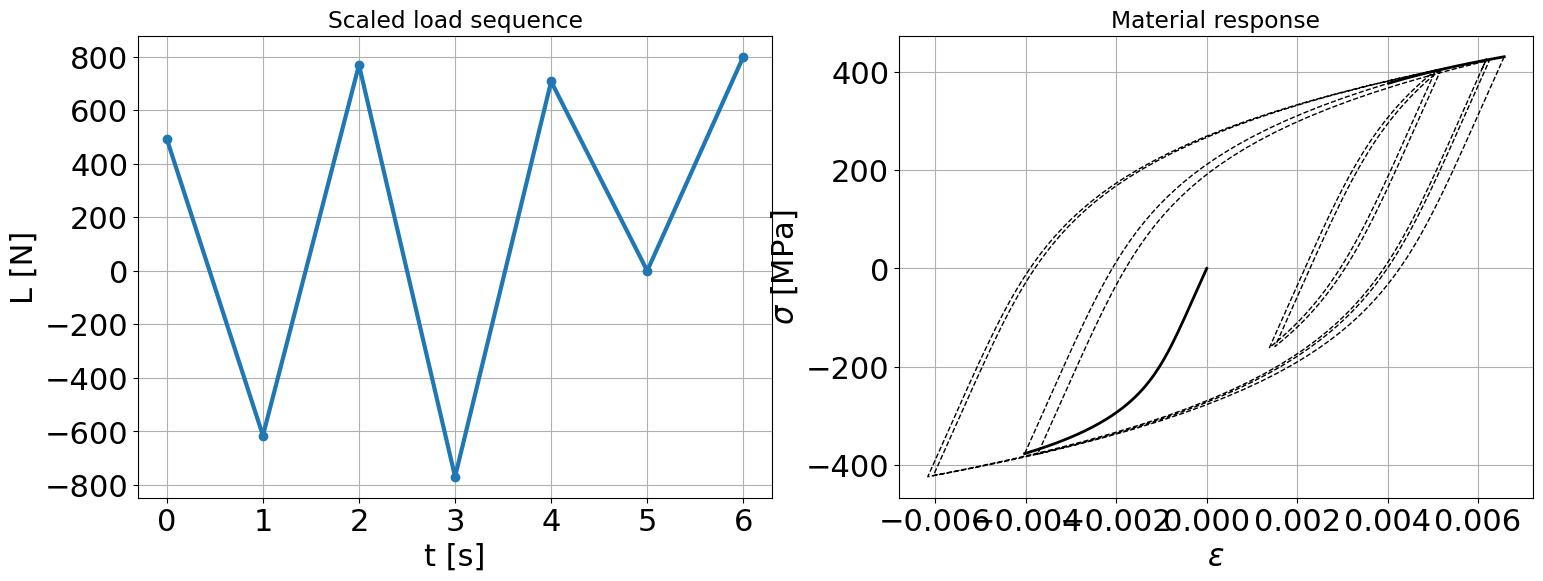

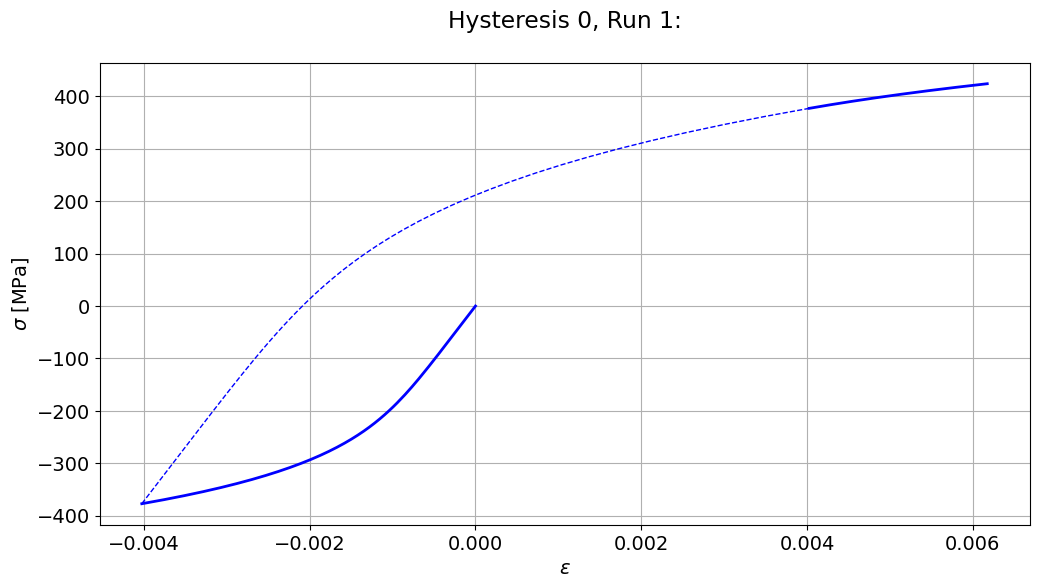

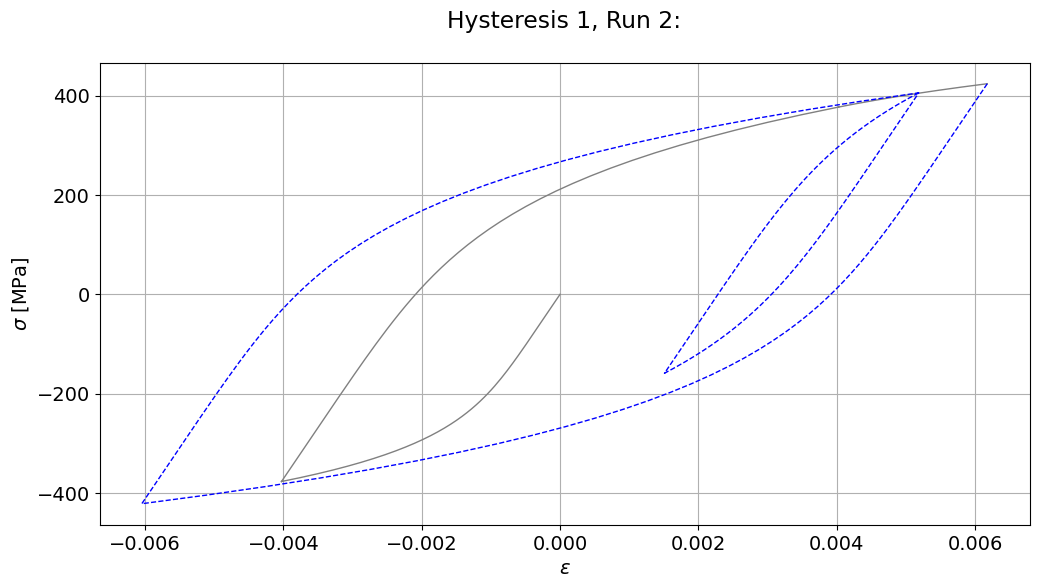

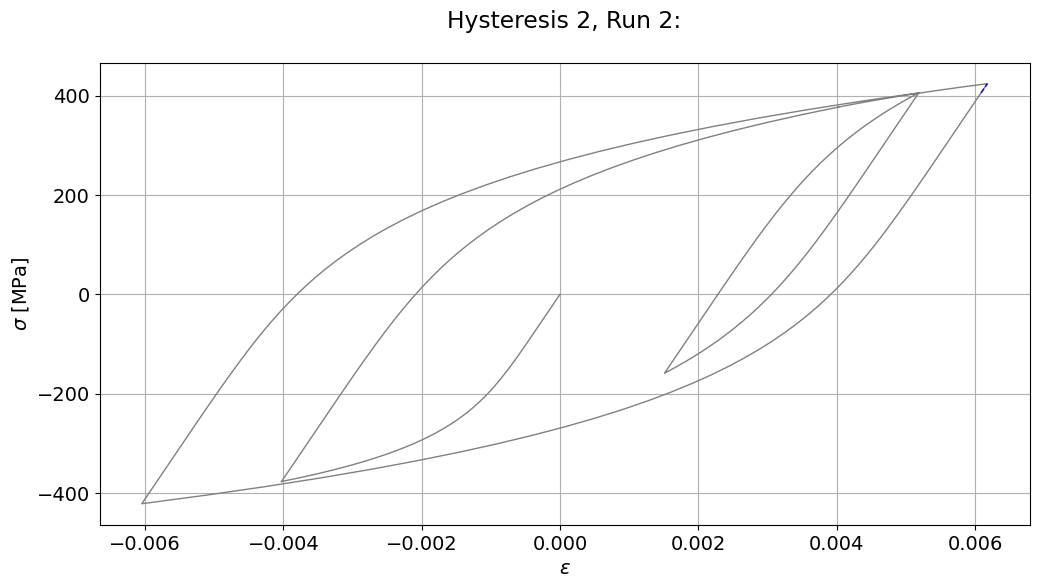

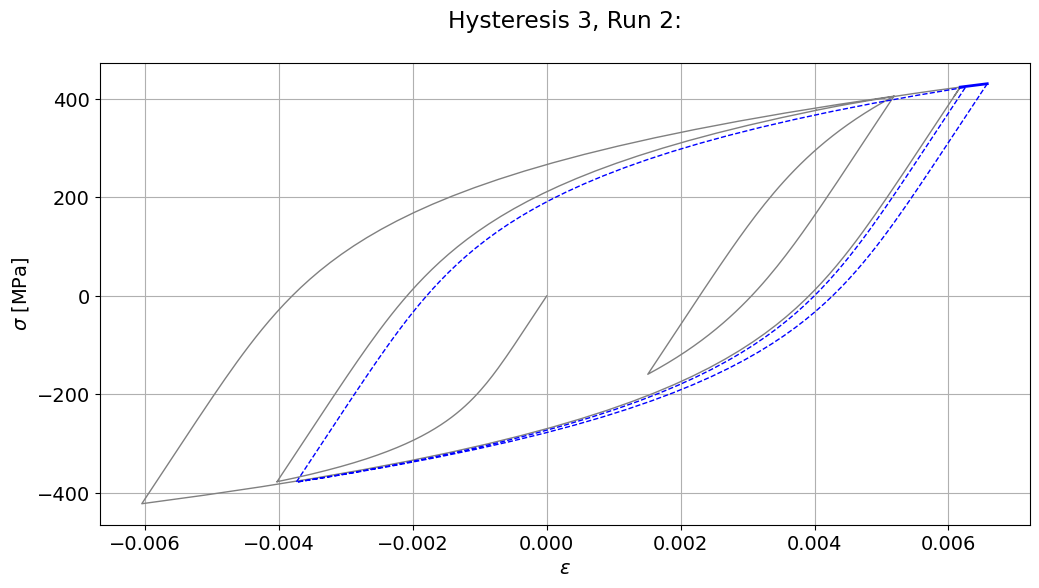

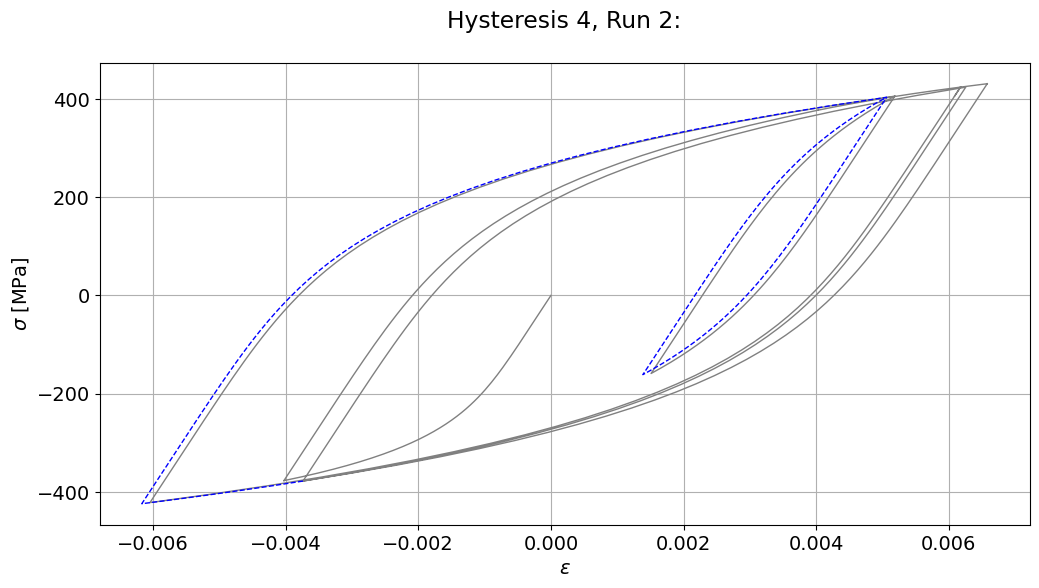

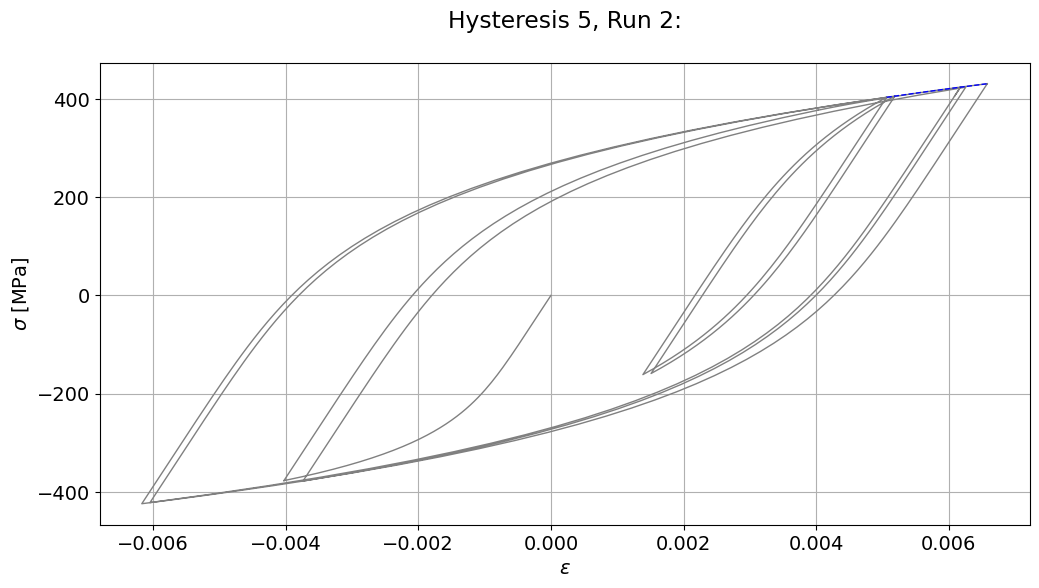

In [31]:
# plot resulting stress-strain curve
sampling_parameter = 50    # choose larger for smoother plot
strain_values_primary, stress_values_primary, hysteresis_index_primary, \
strain_values_secondary, stress_values_secondary, hysteresis_index_secondary \
    = detector.interpolated_stress_strain_data(sampling_parameter)

# all hystereses in stress-strain diagram
fig, axes = plt.subplots(1, 2, figsize=(18,6))
# load-time diagram
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
axes[0].plot(load_sequence_list, "o-", lw=3)
axes[0].grid()
axes[0].set_xlabel("t [s]")
axes[0].set_ylabel("L [N]")
axes[0].set_title("Scaled load sequence")

# stress-strain diagram
axes[1].plot(strain_values_primary, stress_values_primary, "k-", lw=2)
axes[1].plot(strain_values_secondary, stress_values_secondary, "k--", lw=1)
axes[1].grid()
axes[1].set_xlabel("$\epsilon$")
axes[1].set_ylabel("$\sigma$ [MPa]")
axes[1].set_title("Material response")

# all hystereses in stress-strain diagram
strain_previous = []
stress_previous = []

n_hystereses = max(max(hysteresis_index_primary), max(hysteresis_index_secondary))
for hysteresis_index in range(n_hystereses):

    fig, ax = plt.subplots(figsize=(12,6))
    strain_primary_subset = np.where(hysteresis_index_primary == hysteresis_index, strain_values_primary, np.nan)
    stress_primary_subset = np.where(hysteresis_index_primary == hysteresis_index, stress_values_primary, np.nan)

    strain_secondary_subset = np.where(hysteresis_index_secondary == hysteresis_index, strain_values_secondary, np.nan)
    stress_secondary_subset = np.where(hysteresis_index_secondary == hysteresis_index, stress_values_secondary, np.nan)

    run_index = damage_parameter.collective.iloc[hysteresis_index, damage_parameter.collective.columns.get_loc("run_index")]
    debug_output = damage_parameter.collective.iloc[hysteresis_index, damage_parameter.collective.columns.get_loc("debug_output")]
    ax.set_title(f"Hysteresis {hysteresis_index}, Run {run_index}:\n{debug_output}")
    ax.plot(strain_previous, stress_previous, "gray", lw=1)
    ax.plot(strain_primary_subset, stress_primary_subset, "b-", lw=2)
    ax.plot(strain_secondary_subset, stress_secondary_subset, "b--", lw=1)
    ax.grid()
    ax.set_xlabel("$\epsilon$")
    ax.set_ylabel("$\sigma$ [MPa]")
    
    # add the new hysteresis to every next plot
    strain_previous += list(strain_primary_subset)
    stress_previous += list(stress_primary_subset)
    strain_previous += list(strain_secondary_subset)
    stress_previous += list(stress_secondary_subset)
    

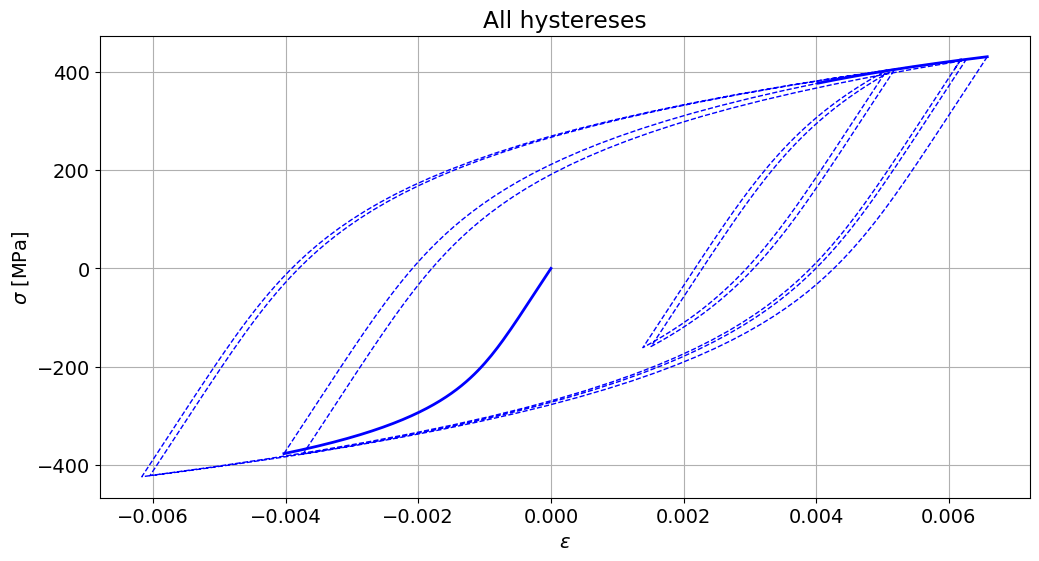

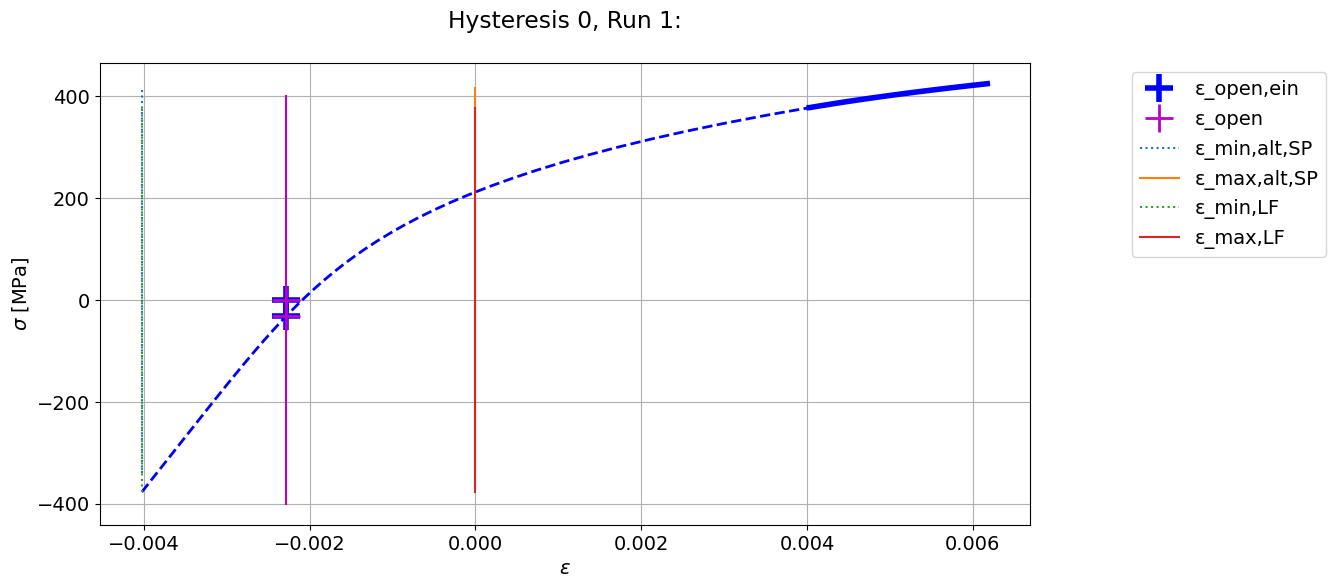

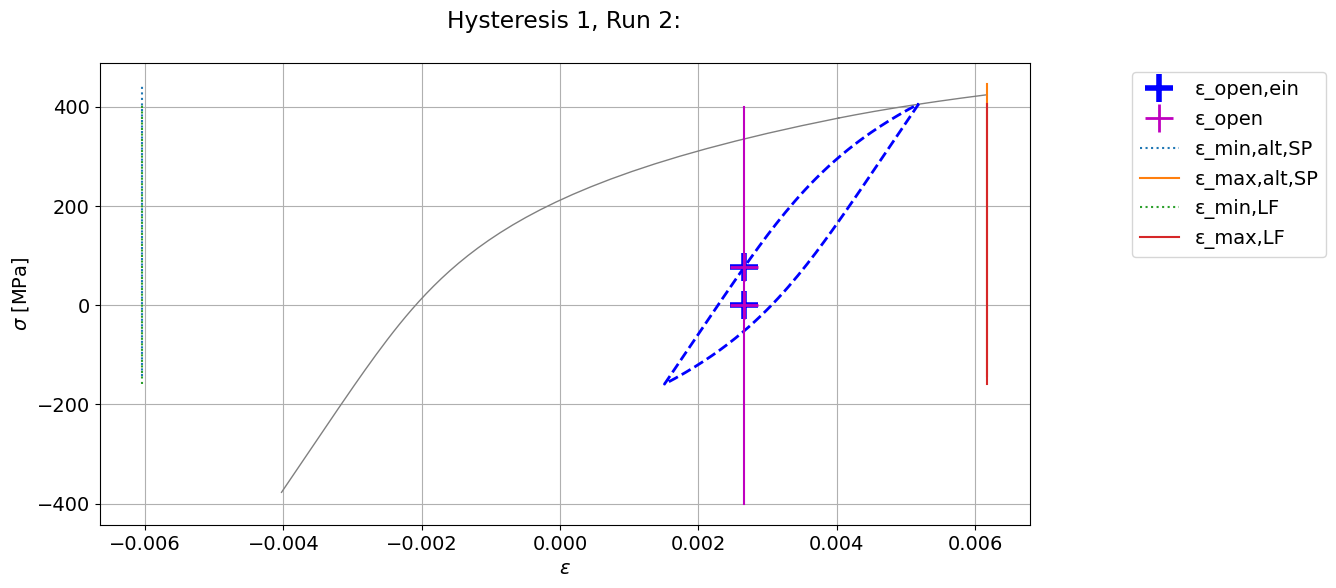

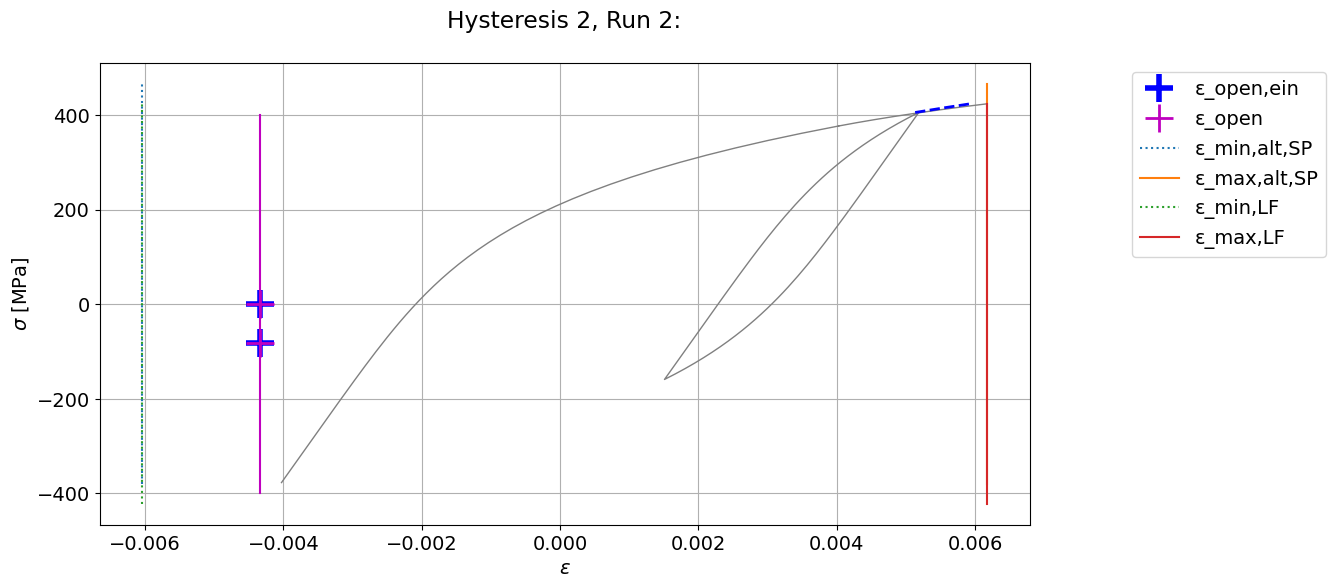

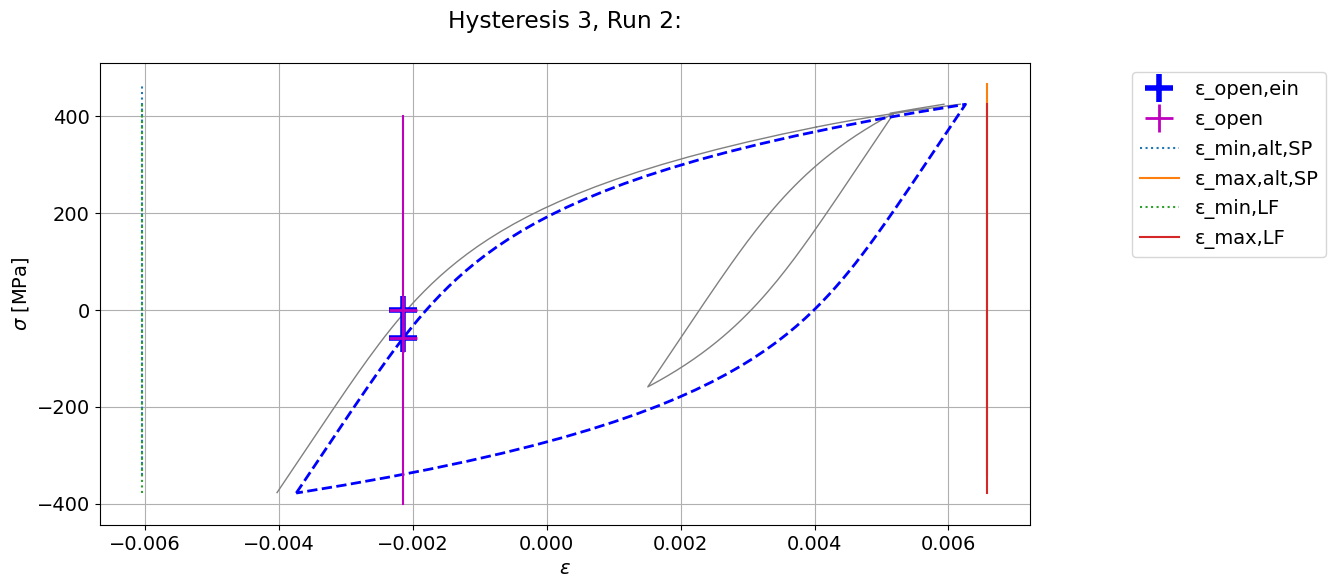

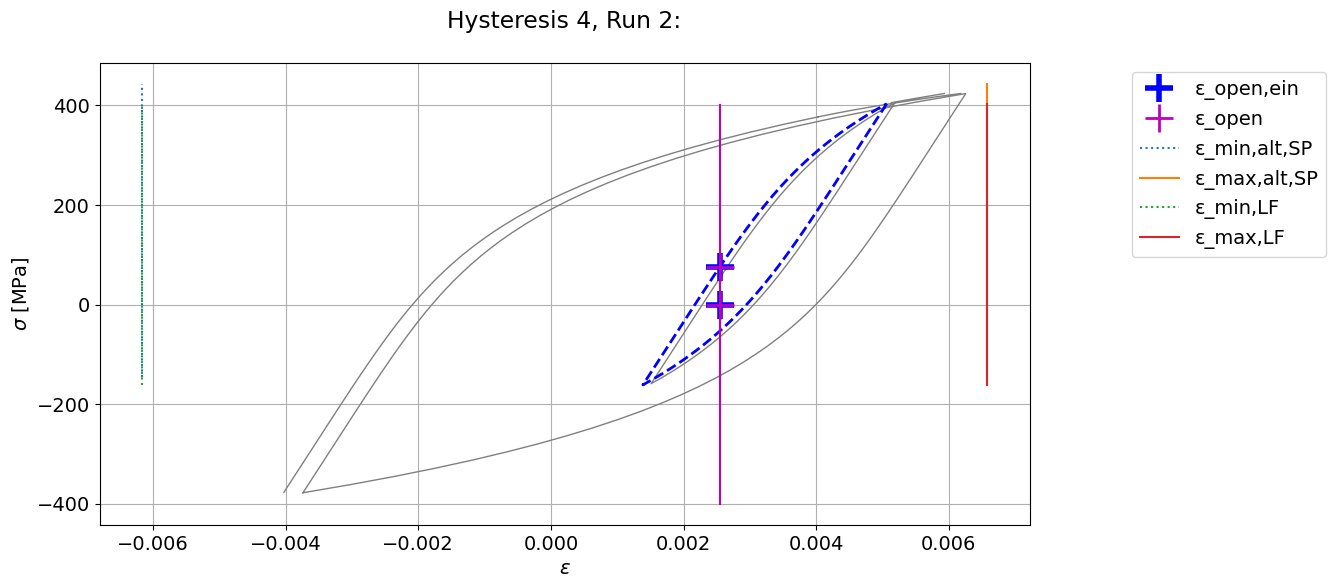

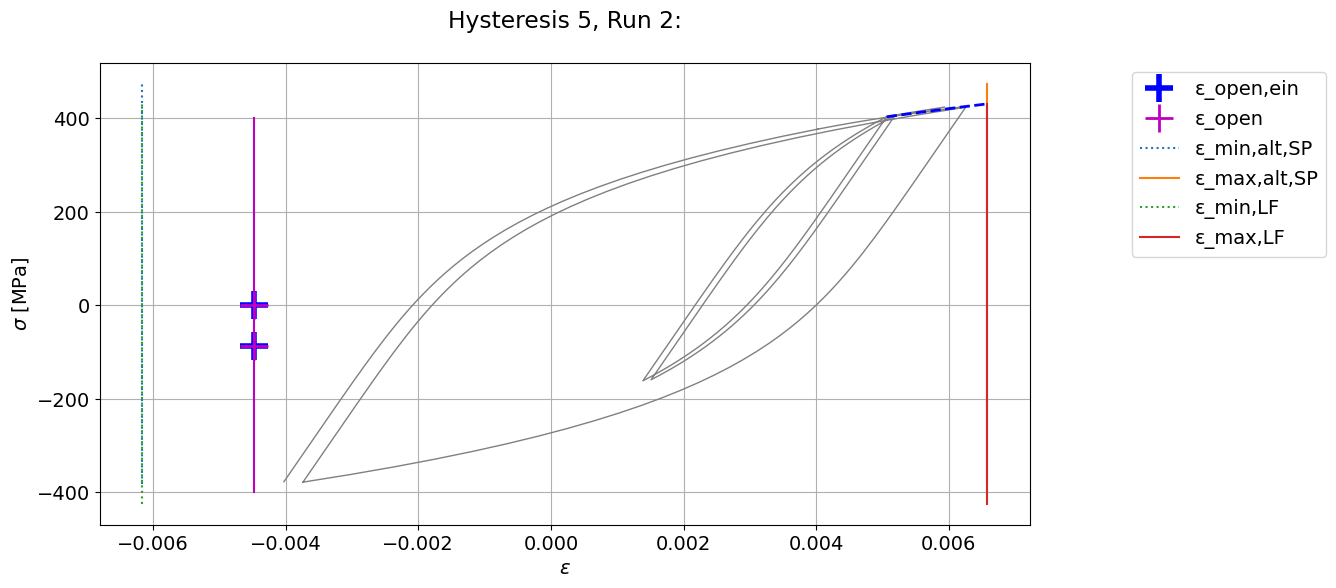

In [32]:
# plot all hystereses
# get all graph data
sampling_parameter = 50    # choose larger for smoother plot
strain_values_primary_all, stress_values_primary_all, hysteresis_index_primary, \
strain_values_secondary_all, stress_values_secondary_all, hysteresis_index_secondary \
    = detector.interpolated_stress_strain_data(sampling_parameter, only_hystereses=False)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strain_values_primary, stress_values_primary, "b-", lw=2)
ax.plot(strain_values_secondary, stress_values_secondary, "b--", lw=1)
ax.grid()
ax.set_xlabel("$\epsilon$")
ax.set_ylabel("$\sigma$ [MPa]")
ax.set_title("All hystereses")


collective = damage_parameter.collective

# get graph data of only hystereses
sampling_parameter = 50    # choose larger for smoother plot
strain_values_primary, stress_values_primary, hysteresis_index_primary, \
strain_values_secondary, stress_values_secondary, hysteresis_index_secondary \
    = detector.interpolated_stress_strain_data(sampling_parameter, only_hystereses=True)

# plot only hystereses
strain_previous = []
stress_previous = []
n_hystereses = max(max(hysteresis_index_primary), max(hysteresis_index_secondary))
for hysteresis_index in range(n_hystereses):

    fig, ax = plt.subplots(figsize=(12,6))
    
    # plot hysteresis
    strain_primary_subset = np.where(hysteresis_index_primary == hysteresis_index, strain_values_primary, np.nan)
    stress_primary_subset = np.where(hysteresis_index_primary == hysteresis_index, stress_values_primary, np.nan)

    strain_secondary_subset = np.where(hysteresis_index_secondary == hysteresis_index, strain_values_secondary, np.nan)
    stress_secondary_subset = np.where(hysteresis_index_secondary == hysteresis_index, stress_values_secondary, np.nan)

    if len([_ for _ in strain_primary_subset if not np.isnan(_)]) == 0 and \
        len([_ for _ in strain_secondary_subset if not np.isnan(_)]) == 0:
        strain_primary_subset = np.array(strain_values_primary_all)
        stress_primary_subset = np.array(stress_values_primary_all)
        strain_secondary_subset = np.array(strain_values_secondary_all)
        stress_secondary_subset = np.array(stress_values_secondary_all)
    
    run_index = collective.iloc[hysteresis_index, collective.columns.get_loc("run_index")]
    #case_debugging = collective.iloc[hysteresis_index, collective.columns.get_loc("case_debugging")]
    case_debugging = ""
    ax.set_title(f"Hysteresis {hysteresis_index}, Run {run_index}:\n{case_debugging}")
    ax.plot(strain_previous, stress_previous, "gray", lw=1)
    ax.plot(strain_primary_subset, stress_primary_subset, "b-", lw=4)
    ax.plot(strain_secondary_subset, stress_secondary_subset, "b--", lw=2)
    
    # plot crack opening points
    S_open = collective.iloc[hysteresis_index, collective.columns.get_loc("S_open")]
    S_close = collective.iloc[hysteresis_index, collective.columns.get_loc("S_close")]
    epsilon_open = collective.iloc[hysteresis_index, collective.columns.get_loc("epsilon_open")]
    epsilon_open_ein = collective.iloc[hysteresis_index, collective.columns.get_loc("epsilon_open_ein")]
    
    ax.plot(epsilon_open_ein, S_open, "+", markersize=20, markeredgewidth=4, color="b", label="ε_open,ein")
    ax.plot(epsilon_open_ein, S_close, "+", markersize=20, markeredgewidth=4, color="b")
    
    ax.plot(epsilon_open, S_open, "+", markersize=20, markeredgewidth=2, color="m", label="ε_open")
    ax.plot(epsilon_open, S_close, "+", markersize=20, markeredgewidth=2, color="m")
    ax.plot([epsilon_open, epsilon_open], 
            [-400,400], "-", color="m")
    
    # plot epsilons
    S_min = collective.iloc[hysteresis_index, collective.columns.get_loc("S_min")]
    S_max = collective.iloc[hysteresis_index, collective.columns.get_loc("S_max")]
    
    epsilon_min_alt_SP = collective.iloc[hysteresis_index, collective.columns.get_loc("epsilon_min_alt_SP")]
    epsilon_max_alt_SP = collective.iloc[hysteresis_index, collective.columns.get_loc("epsilon_max_alt_SP")]
    epsilon_min_LF = collective.iloc[hysteresis_index, collective.columns.get_loc("epsilon_min_LF")]
    epsilon_max_LF = collective.iloc[hysteresis_index, collective.columns.get_loc("epsilon_max_LF")]
    
    
    # add the new hysteresis to every next plot
    strain_previous += list(strain_primary_subset)
    stress_previous += list(stress_primary_subset)
    strain_previous += list(strain_secondary_subset)
    stress_previous += list(stress_secondary_subset)
    
    ax.plot([epsilon_min_alt_SP,epsilon_min_alt_SP], [S_min*0.9,S_max*1.1], ":", label="ε_min,alt,SP")
    ax.plot([epsilon_max_alt_SP,epsilon_max_alt_SP], [S_min*0.9,S_max*1.1], "-", label="ε_max,alt,SP")
    ax.plot([epsilon_min_LF,epsilon_min_LF], [S_min,S_max], ":", label="ε_min,LF")
    ax.plot([epsilon_max_LF,epsilon_max_LF], [S_min,S_max], "-", label="ε_max,LF")
    
    ax.grid()
    ax.legend(bbox_to_anchor=(1.1,1), loc="upper left")
    ax.set_xlabel("$\epsilon$")
    ax.set_ylabel("$\sigma$ [MPa]")
    

In [33]:
hysteresis_index_primary

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

### 2.9.9.1, 2.8.10.1 Infinite life assessment (Dauerfestigkeitsnachweis)

In [34]:
# Infinite life assessment
is_life_infinite = damage_calculator.is_life_infinite
print(f"Infinite life:                     {is_life_infinite}")

Infinite life:                     False


### 2.9.8.4, 2.8.10.2 Finite life assessment (Betriebsfestigkeitsnachweis)

In [35]:
# finite life assessment
lifetime_n_cycles = damage_calculator.lifetime_n_cycles
lifetime_n_times_load_sequence = damage_calculator.lifetime_n_times_load_sequence

print(f"Number of bearable cycles:         {lifetime_n_cycles:.0f}")
print(f"Number of bearable load sequences: {lifetime_n_times_load_sequence:.0f}")

Number of bearable cycles:         273
Number of bearable load sequences: 55
